<a href="https://colab.research.google.com/github/enVives/Caltech101/blob/main/Caltech101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [373]:
from itertools import filterfalse
from collections import OrderedDict
#!pip install ultralytics
from ultralytics import YOLO
import torch,torchvision
import numpy as np
import pandas as pd
import math
import cv2
import time
import os
import wandb
import shutil
import pylab as pl
import scipy.io
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from torchvision import transforms,models
from torch import nn
from IPython.display import clear_output,display
from torch.utils.data import DataLoader, random_split,Subset,Dataset
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from glob import glob

ROOT = './sample_data/'
CLASS_A = 'cougar_body'
CLASS_B = 'windsor_chair'

DOWNLOAD = False
DUPLICAR_DADES = True
wandb.login()
#471be466c8949671a46c67e7aad0d5a0ac8c9dad
#!rm -rf /content/sample_data/*


# !rm -rf /content/dataset/images/*
# !rm -rf /content/dataset/labels/*/*
torch.cuda.default_stream(torch.device('cuda'))

<torch.cuda.Stream device=cuda:0 cuda_stream=0x0>

In [374]:
def find_mean_std(dataset):
  dataloader = DataLoader(dataset,batch_size = 1,shuffle=FALSE)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  samples = 0

  for image,_ in dataloader:
    mean += image.mean(dim=[0, 2, 3])  # Mean for each channel [batchsize,channels,height,width]
    std += image.std(dim=[0, 2, 3])    # Std for each channel
    samples += 1

  mean /= samples
  std /= samples

  print(mean)
  print(std)

In [375]:
from pickle import NONE

class Formes(Dataset):
    def __init__(self, paths, labels= None, transforms = None,annotations = None,transform_mask = None):
        self.images = paths
        self.labels = labels
        self.transforms = transforms
        self.annotations = annotations
        self.transforms_mask = transform_mask

    def __len__(self):
        return len(self.labels)

    def __setmodel__(self,model):
        self.model = model

    def __getdist__(self):
      return pd.Series(self.labels).value_counts()

    def __showcontours__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      plt.imshow(image)

      mat_data = scipy.io.loadmat(self.annotations[index])
        #print("Keys in MAT file:", polygons_data.keys())

      polygons_data = mat_data['obj_contour']

      x_points = polygons_data[0]
      y_points = polygons_data[1]

      contour_points = np.array(list(zip(x_points,y_points)))

      plt.plot(contour_points[:, 0], contour_points[:, 1], '-r')  # Red contour line
      plt.scatter(contour_points[:, 0], contour_points[:, 1], c='blue')  # Optional: Mark contour points
      plt.show()

    def __getpureimage__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      return image

    def __getitem__(self, index):
      path = self.images[index]
      label = self.labels[index]

      seed = torch.random.seed()  # Create a unique seed for random operations

      if self.annotations != None:
        mat_data = scipy.io.loadmat(self.annotations[index])


        polygons_data = mat_data['obj_contour']
        boundingbox_data = mat_data['box_coord']

        # print("Keys in MAT file:", mat_data.keys())

        x_points = polygons_data[0]
        y_points = polygons_data[1]

        contour_points = list(zip(x_points,y_points))
        contour = np.array(contour_points, dtype=np.int32)

        #print(contour_points)


      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      if self.model == 3:
        mask = np.zeros(image.size, dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=255)  # White filled polygon
        mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image

        torch.random.manual_seed(seed)  # Set seed for image
        mask_resized = self.transforms_mask(mask)
        mask_resized = (mask_resized > 0.5).float()

        torch.random.manual_seed(seed)  # Set seed for image
        image = self.transforms(image)

        return image, mask_resized

      image = self.transforms(image)

      return image, label

In [376]:
def get_labels(sett):
  labels = np.array([])
  frequency = np.zeros(101)
  for _,label in sett:
    labels = np.append(labels,label)
    frequency[label] += 1
  return labels.astype(int),frequency

In [377]:
def escriu_informacio_yolo(carpeta,nom_imatge,annotations,class_id,image_size):

    label_file = os.path.join(carpeta, f"{os.path.splitext(nom_imatge)[0]}.txt")
    with open(label_file, "w") as f:
            y_min, y_max, x_min, x_max = annotations[0]

            if x_max > image_size[0]:
              x_max = image_size[0]
            if y_max > image_size[1]:
              y_max = image_size[1]

            if image_size:
                img_width, img_height = image_size
                x_center = ((x_min + x_max) / 2) / img_width
                y_center = ((y_min + y_max) / 2) / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height
            else:
                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2
                width = x_max - x_min
                height = y_max - y_min

            # Escribe en el archivo
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

In [378]:
from re import X
#from pickle import FALSE
from sklearn.model_selection import train_test_split

TRAINING = 0.80
VAL = 0.10
TESTING = 0.10

#[0.5459, 0.5288, 0.5022]
#[0.2424, 0.2393, 0.2409]
mean = torch.tensor([0.485,0.456,0.406])
std = torch.tensor([0.229,0.224,0.225])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_masks = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])


transform2 = transforms.Compose([
    #transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # Ensure all images are RGB
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.Caltech101(root= ROOT,download=DOWNLOAD,transform=transform)

img_class_1 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/cougar_body/*'))
img_class_2 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/windsor_chair/*'))

img_annotations_class_1 = sorted(glob('/content/sample_data/caltech101/Annotations/cougar_body/*'))
img_annotations_class_2 = sorted(glob('/content/sample_data/caltech101/Annotations/windsor_chair/*'))


img_files = img_class_1 +  img_class_2
img_annotations = img_annotations_class_1 + img_annotations_class_2

if DUPLICAR_DADES:
  img_files_duplicated = img_files + img_files  # Duplicate image paths
  img_annotations_duplicated = img_annotations + img_annotations  # Duplicate annotation paths

  img_files = img_files_duplicated
  img_annotations = img_annotations_duplicated

labels = []
for img_path in img_files:
  label = img_path.split(os.path.sep)[-2]
  labels.append(label)

lb = LabelEncoder()
labels = lb.fit_transform(labels)

weights = 1.0 / pd.Series(labels).value_counts()
weights = weights / weights.sum()
weights = torch.tensor(weights,dtype=torch.float32)


X_train, X_test, y_train, y_test, annotations_train, annotations_test = train_test_split(
    img_files, labels, img_annotations, test_size=TESTING, random_state=42, stratify=labels
)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val, annotations_train, annotations_val = train_test_split(
    X_train, y_train, annotations_train, test_size=VAL/(TRAINING+VAL), random_state=42, stratify=y_train
)

training = Formes(X_train,y_train,transform2,annotations_train,transform_masks)
testing = Formes(X_test,y_test,transform,annotations_test,transform_masks)
validation = Formes(X_val,y_val,transform,annotations_val,transform_masks)

if DOWNLOAD:

  #Preparar informació per YOLO

  carpeta_yolo = "dataset"

  if not os.path.exists(carpeta_yolo):
      os.mkdir(carpeta_yolo)

  #cream l'estructura que utilitzarà yolo de ultralitics

  directoris = ["dataset/train/","dataset/test/","dataset/val/","dataset/train/images/","dataset/train/labels/","dataset/val/images/","dataset/val/labels/","dataset/test/images/","dataset/test/labels/"]

  for carpeta in directoris:
    if not os.path.exists(carpeta):
      os.mkdir(carpeta)

  for elemento in X_train:
    shutil.copy(elemento, "/content/dataset/train/images")

  for elemento in X_val:
    shutil.copy(elemento, "/content/dataset/val/images")

  for elemento in X_test:
    shutil.copy(elemento, "/content/dataset/test/images")

  #ara a les carpetes de labels training, validation i testing hi afegirem la informació:
  #class_id,x_center,y_center,width,height de cada imatge que es el que requereix YOLOv5

  for i in range(len(X_train)):
    mat_data = scipy.io.loadmat(annotations_train[i])
    nom = X_train[i].split("/")[-1]
    label = y_train[i]
    boundingbox_data = mat_data['box_coord']
    width,height = Image.open(X_train[i]).size

    escriu_informacio_yolo("dataset/train/labels/",nom,boundingbox_data,label,(width,height))

  for i in range(len(X_val)):
    mat_data = scipy.io.loadmat(annotations_val[i])
    nom = X_val[i].split("/")[-1]
    label = y_val[i]
    boundingbox_data = mat_data['box_coord']
    width,height = Image.open(X_val[i]).size

    escriu_informacio_yolo("dataset/val/labels/",nom,boundingbox_data,label,(width,height))

  for i in range(len(X_test)):
    mat_data = scipy.io.loadmat(annotations_test[i])
    nom = X_test[i].split("/")[-1]
    label = y_test[i]
    boundingbox_data = mat_data['box_coord']
    width,height = Image.open(X_test[i]).size

    escriu_informacio_yolo("dataset/test/labels/",nom,boundingbox_data,label,(width,height))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#training,validation,testing = random_split(dataset,[train_size,validation_size,len(dataset)-train_size-validation_size])

In [379]:
print(f"LONGITUD SET DE TRAINING: {training.__len__()}")
with open("training.txt", "w") as file:
    for item in training.__getdist__()/training.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE VALIDATION: {validation.__len__()}")
with open("valid.txt", "w") as file:
    for item in validation.__getdist__()/validation.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE TESTING: {testing.__len__()}")

LONGITUD SET DE TRAINING: 164
LONGITUD SET DE VALIDATION: 21
LONGITUD SET DE TESTING: 21


Ara ja sabem que hem de predir si una imatge pertany a les classes 25 o 99

In [380]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data[i]

    print(imatge.ndimension())
    print(imatge.shape)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)
    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [381]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        dropout_prob = 0.1

        ## CODER
        self.encoder1 = UNet._block(in_channels, features, name="enc1", dropout_prob=0.0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2", dropout_prob=0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3", dropout_prob=0.5)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4", dropout_prob=0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck", dropout_prob=0.5)

        ## DECODER

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2,
                                          stride=2)  # Empra aquesta capa com exemple
        self.decoder4 = UNet._block(features * 16, features * 8, name="dec4",dropout_prob=0)

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 8, features * 4, name="dec3",dropout_prob=0)

        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 4, features * 2, name="dec2",dropout_prob=0)

        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1",dropout_prob=0)

        self.final = nn.Conv2d(
            in_channels=features,
            out_channels=out_channels,
            kernel_size=1,
            padding=0,
            bias=False,
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec1 = self.upconv4(bottleneck)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec2 = self.decoder4(dec1)

        dec2 = self.upconv3(dec2)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec3 = self.decoder3(dec2)

        dec3 = self.upconv2(dec3)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec4 = self.decoder2(dec3)

        dec4 = self.upconv1(dec4)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec5 = self.decoder1(dec4)
        return torch.sigmoid(self.final(dec5))

    @staticmethod
    def _block(in_channels, features, name,dropout_prob):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1",
                     nn.Conv2d(
                         in_channels=in_channels,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "dropout1", nn.Dropout2d(p=dropout_prob)),

                    (name + "conv2",
                     nn.Conv2d(
                         in_channels=features,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                    (name + "dropout2", nn.Dropout2d(p=dropout_prob)),
                ]
            )
        )

In [382]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 0.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
                y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [383]:
def pick_algorithm(number):
  if number == 0:
    alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1) #fine tuning
    # Modify the classifier
    alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    loss_fn = nn.BCEWithLogitsLoss()
    #loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
    return alexnet,loss_fn
  elif number == 1:
    vgg = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
    vgg.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    loss_fn = nn.BCEWithLogitsLoss()
    return vgg,loss_fn
  elif number == 2:
    resnet = models.resnet18(weights="IMAGENET1K_V1")
    resnet.fc = nn.Linear(in_features=512, out_features=1)
    loss_fn = nn.BCEWithLogitsLoss()

    return resnet,loss_fn
  elif number == 3:
    unet = UNet(3,1)
    loss_fn = DiceLoss()
    return unet,loss_fn
  elif number == 5:
    model = YOLO('yolov5n.pt')
    return model,None
  elif number == 4: #model propi
    model = nn.Sequential(

        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.AdaptiveAvgPool2d(output_size=(6, 6)),

        nn.Flatten(),
        nn.Dropout(p=0.1),
        nn.Linear(9216, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1)
    )

    return model, nn.BCEWithLogitsLoss()

In [384]:
BATCH_SIZE = 8
EPOCHS = 90
PATIENCE = 30

architectures = {'alexnet': 0,'vgg': 1,'resnet': 2,'unet':3,'propi':4,'yolo':5,'rcnn':6}
architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet',3:'unet',4:'propi',5:'yolo',6:'rcnn'}
projectes = ['caltech101-Alexnet','caltech101-Vgg','caltech101-ResNet','caltech101-unet','caltech101-Propi']

MODEL = architectures['unet']

training.__setmodel__(MODEL)
validation.__setmodel__(MODEL)
testing.__setmodel__(MODEL)

train_loader = torch.utils.data.DataLoader(training, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing, batch_size=testing.__len__(), shuffle=True)

model,loss_fn = pick_algorithm(MODEL)
model.to(device)

learning_rate = 0.00015
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if MODEL != architectures['yolo']:
  wandb.init(
          project=projectes[MODEL],
          config={
              "epochs": EPOCHS,
              "batch_size": BATCH_SIZE,
              "lr": learning_rate,
              "trsize":training.__len__(),
              "trdist":TRAINING,
              "vsize":validation.__len__(),
              "vdist":VAL,
              "duplicated":DUPLICAR_DADES,
              "dropout": 0.1
              })


  config = wandb.config

test_target = None
test_output = None

#veure_imatges(training,std,mean)

In [385]:
img, target= next(iter(train_loader))
print(img.shape)

torch.Size([8, 3, 224, 224])


In [386]:
def fit(model,loss_fn,dataloader,optimizer,epoch):

  batch_num = 1
  train_loss = 0
  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0

  example_ct = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):

        model.train()

        optimizer.zero_grad()
        #extreu_classes(target.to(device))

        output = model(input_img.to(device))

        #print(target.shape)
        # print(target)
        #print(output.shape)
        # print(output)



        if MODEL != architectures['unet']:
          target = target.float().unsqueeze(1)
        else:
          target = target.to(dtype=torch.float32)


        target = target.to(device)
        loss = loss_fn(output, target)


        model.zero_grad()
        loss.backward()

        with torch.no_grad():
          optimizer.step()


        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        model.eval()

        # print("Target unique values and counts:", torch.unique(target, return_counts=True))
        # print("Output unique values and counts:", torch.unique((output > 0.5).int(), return_counts=True))


        if MODEL == architectures['unet']:
            output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
            target = target.view(-1).cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)
          output = (output.cpu().detach().numpy() > 0.5).astype(int)
          target = target.cpu().detach().numpy()


        y_class_predict = output



        a= accuracy_score(target,y_class_predict)
        b= f1_score(target,y_class_predict,zero_division=1)
        c= recall_score(target,y_class_predict,zero_division=1)
        d= precision_score(target,y_class_predict,zero_division=1)
        e = loss.item()



        train_acc += a
        train_f1 += b
        train_recall += c
        train_precision += d
        train_loss += e

        example_ct += len(input_img)

  return train_acc,train_f1,train_recall,train_precision,train_loss

In [387]:

def validate(model,data_loader,loss_fn):

  val_acc = 0
  val_recall = 0
  val_f1 = 0
  val_loss = 0
  val_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)

            if MODEL != architectures['unet']:
              target = target.float().unsqueeze(1)
            else:
              target = target.to(dtype=torch.float32)

            loss = loss_fn(output, target)



            if MODEL == architectures['unet']:
              output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
              target = target.view(-1).cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)
              output = (output.cpu().detach().numpy() > 0.5).astype(int)
              target = target.cpu().detach().numpy()


            # with open("outputtarget.txt", "w") as file:
            #   file.write(f"OUTPUT\n")
            #   np.savetxt(file, output, fmt="%d")  # Save output as integers
            #   file.write(f"TARGET\n")
            #   np.savetxt(file, target, fmt="%d")  # Save output as integers

            y_class_predict = output

            val_acc  += accuracy_score(target,y_class_predict)
            val_f1 += f1_score(target,y_class_predict,zero_division=1)
            val_recall += recall_score(target,y_class_predict,zero_division=1)
            val_precision += precision_score(target,y_class_predict,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [388]:
def test(model,data_loader,loss_fn):

  global test_target
  global test_output


  test_acc = 0
  test_recall = 0
  test_f1 = 0
  test_loss = 0
  test_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)

            if MODEL != architectures['unet']:
              target = target.float().unsqueeze(1)
            else:
              target = target.to(dtype=torch.float32)

            loss = loss_fn(output, target)



            if MODEL == architectures['unet']:

              output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
              target = target.view(-1).cpu().detach().numpy()

              test_output = output
              test_target = target

            else:
              output = torch.sigmoid(output)
              output = (output.cpu().detach().numpy() > 0.5).astype(int)
              target = target.cpu().detach().numpy()


            # with open("outputtarget.txt", "w") as file:
            #   file.write(f"OUTPUT\n")
            #   np.savetxt(file, output, fmt="%d")  # Save output as integers
            #   file.write(f"TARGET\n")
            #   np.savetxt(file, target, fmt="%d")  # Save output as integers

            y_class_predict = output

            test_acc  += accuracy_score(target,y_class_predict)
            test_f1 += f1_score(target,y_class_predict,zero_division=1)
            test_recall += recall_score(target,y_class_predict,zero_division=1)
            test_precision += precision_score(target,y_class_predict,zero_division=1)

            test_loss += loss.item()

  return test_acc,test_f1,test_recall,test_precision,test_loss

In [389]:
def prova():
  t_loss = np.zeros(EPOCHS)
  v_loss = np.zeros(EPOCHS)
  acc_t = np.zeros(EPOCHS) #accuracy
  acc_v = np.zeros(EPOCHS)
  f1_t = np.zeros(EPOCHS) #f1
  f1_v = np.zeros(EPOCHS)
  recall_t = np.zeros(EPOCHS) #recall
  recall_v = np.zeros(EPOCHS)
  precision_t = np.zeros(EPOCHS)
  precision_v = np.zeros(EPOCHS) #precisió

  epochs_without_improvement = 0
  best_val_loss = float('inf')
  best_val_acc = 0
  pbar = tqdm(range(1, EPOCHS + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:


    train_acc,train_f1,train_recall,train_precision,train_loss = fit(model,loss_fn,train_loader,optimizer,epoch)

    val_acc,val_f1,val_recall,val_precision,val_loss = validate(model,validation_loader,loss_fn)

    test_acc,test_f1,test_recall,test_precision,test_loss = test(model,testing_loader,loss_fn)

    training_metrics = {"train/train_loss": train_loss/len(train_loader),
                    "train/train_acc":train_acc/len(train_loader),
                    "train/train_f1":train_f1/len(train_loader),
                    "train/train_recall":train_recall/len(train_loader),
                    "train/train_precision":train_precision/len(train_loader)}

    val_metrics = {"val/val_loss": val_loss/len(validation_loader),
                  "val/val_acc":val_acc/len(validation_loader),
                  "val/val_f1":val_f1/len(validation_loader),
                  "val/val_recall": val_recall/len(validation_loader),
                  "val/val_precision": val_precision/len(validation_loader)}

    testing_metrics = {"test/test_loss": test_loss/len(testing_loader),
                       "test/test_acc": test_acc/len(testing_loader),
                       "test/test_f1":test_f1/len(testing_loader),
                       "test/test_recall": test_recall/len(testing_loader),
                        "test/test_precision": test_precision/len(testing_loader)}

    #Early Stopping:

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
    else:
      # print("Early stopping triggered!")
      # break
        epochs_without_improvement += 1

    #Saving the results

    wandb.log({**training_metrics, **val_metrics,**testing_metrics})

    torch.save(model, "my_model.pt")
    wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

    train_loss /= len(train_loader)
    t_loss[epoch - 1] = train_loss

    train_acc /= len(train_loader)
    acc_t[epoch - 1] = train_acc

    train_f1 /= len(train_loader)
    f1_t[epoch - 1] = train_f1

    train_recall /= len(train_loader)
    recall_t[epoch - 1] = train_recall

    train_precision /= len(train_loader)
    precision_t[epoch-1] = train_precision

    print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
    print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
    print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
    print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")
    print(f"Precision train epoch: {epoch}  train_recall: {train_precision}")

    val_loss /= len(validation_loader)
    v_loss[epoch - 1] = val_loss

    val_acc /= len(validation_loader)
    acc_v[epoch - 1] = val_acc

    val_f1 /= len(validation_loader)
    f1_v[epoch - 1] = val_f1

    val_recall /= len(validation_loader)
    recall_v[epoch - 1] = val_recall

    val_precision /= len(validation_loader)
    precision_v[epoch-1] = val_precision

    print()
    print()
    print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
    print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
    print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
    print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")
    print(f"Precision val epoch: {epoch}  val_reall: {val_precision}")

    test_loss /= len(testing_loader)

    test_acc /= len(testing_loader)

    test_f1 /= len(testing_loader)

    test_recall /= len(testing_loader)

    test_precision /= len(testing_loader)

    print()
    print()
    print(f"Pèrdua testing epoch: {epoch}  val_loss: {test_loss}")
    print(f"Accuracy test epoch: {epoch}  val_acc: {test_acc}")
    print(f"F1 test epoch: {epoch}  val_f1: {test_f1}")
    print(f"Recall test epoch: {epoch}  val_reall: {test_recall}")
    print(f"Precision test epoch: {epoch}  val_reall: {test_precision}")

    # if epochs_without_improvement >= PATIENCE:
    #     print("Early stopping triggered!")
    #     break

    # if val_acc > 0.9:
    #   print("Early stopping triggered!")
    #   break

  wandb.finish()

In [390]:
from IPython.display import clear_output

def visualitza_resultats():
    test_output_images = test_output.reshape(testing.__len__(), 224, 224)
    test_target_images = test_target.reshape(testing.__len__(), 224, 224)

    # Set up the figure and axes once
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Hide axes for better clarity
    for ax in axs:
        ax.axis('off')

    # Loop through the images and update
    for i in range(testing.__len__()):
        # Clear the previous output in Colab
        clear_output(wait=True)

        # Clear the axes
        axs[0].cla()
        axs[1].cla()

        # Update the image data for output and target images
        axs[0].imshow(test_output_images[i], cmap='gray', vmin=0, vmax=1)
        axs[1].imshow(test_target_images[i], cmap='gray', vmin=0, vmax=1)

        # Set the titles dynamically
        axs[0].set_title(f"Output {i+1}")
        axs[1].set_title(f"Target {i+1}")

        # Redraw the plot
        display(fig)  # Explicitly display the updated figure
        plt.pause(10)

    # Close the plot window after all images have been shown
    plt.close(fig)

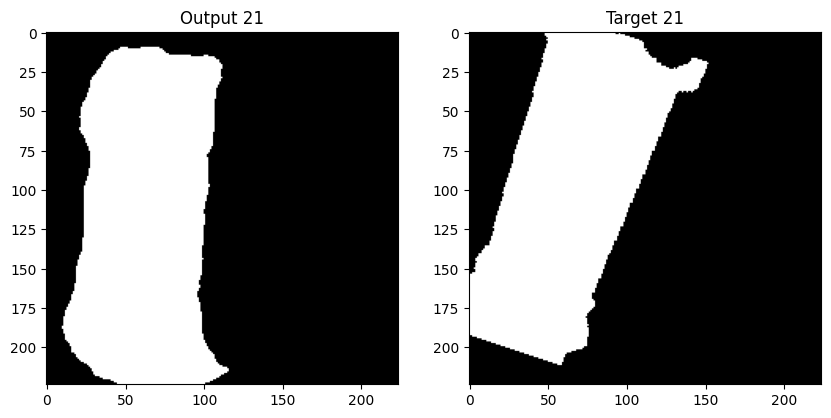

In [391]:
#{'alexnet': 0,'vgg': 1,'resnet': 2,'unet':3,'yolo':4,'propi':5}

if MODEL == architectures['unet']:
  prova()
  visualitza_resultats() #visualitza les màsqueres previstes
elif MODEL != architectures['yolo']:
  torch.use_deterministic_algorithms(False)
  prova()
else: #yolo
  train_results = model.train(
      data="/content/data.yaml",
      epochs=100,
      imgsz=288,
      verbose=True
  )

  metrics = model.val()

  results = model(X_test[0])
  results[0].show()


  path = model.export(format="onnx")

In [392]:
i = 32
mat_data = scipy.io.loadmat(annotations_train[i])
#print(mat_data)
boundingbox_data = mat_data['box_coord']
print(mat_data['box_coord'])
dimensions = Image.open(X_train[i]).size

# print(boundingbox_data)
# print(dimensions)

[[  2 299   2 183]]


In [393]:
print(training.__getdist__())

1    90
0    74
Name: count, dtype: int64


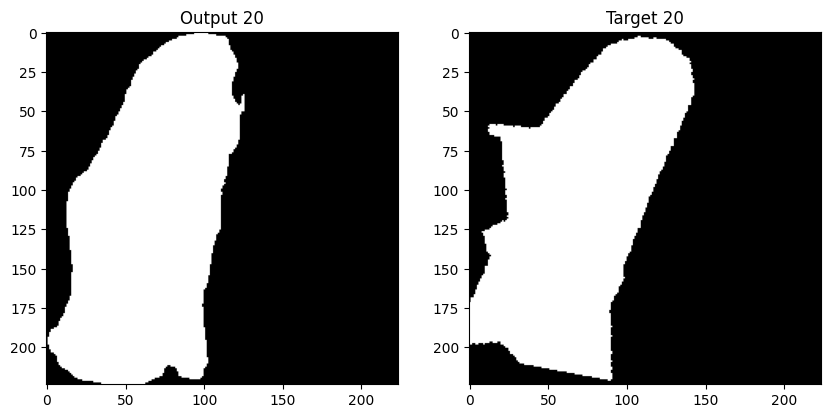

In [ ]:
visualitza_resultats()